In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree, NearestNeighbors
from scipy.spatial import distance
import tracemalloc
from scipy.spatial.distance import cdist, euclidean
import seaborn as sns
import pandas as pd
import heapq
from collections import defaultdict

In [2]:
def custom(point, data):
    return np.array([sum((pi - qi) ** 2 for pi, qi in zip(p, point)) ** 0.5 for p in data])

def np_sqrt(point, data):
    return np.sqrt(np.sum((data - point) ** 2, axis=1))

def linalg_norm(point, data):
    return np.linalg.norm(data - point, axis=1)

def scipy_cdist(point, data):
    return cdist([point], data, metric='euclidean').flatten()

def scipy_loop(point, data):
    return np.array([euclidean(point, p) for p in data])


In [3]:

n = 10
d = 2
data = np.random.randint(1, 101, size=(n, d))

query_point = np.random.randint(1, 101, size=(d,))


distances_custom = custom(query_point, data)
distances_linalg = linalg_norm(query_point, data)
distances_sqrt = np_sqrt(query_point, data)
distances_cdist = scipy_cdist(query_point, data)
distances_einsum = scipy_loop(query_point, data)

df_distances = pd.DataFrame({
    'Point': [tuple(point) for point in data],
    'custom': distances_custom,
    'np.linalg.norm': distances_linalg,
    'np.sqrt': distances_sqrt,
    'scipy.cdist': distances_cdist,
    'np.einsum': distances_einsum,
})

In [4]:
df_distances

,Point,custom,np.linalg.norm,np.sqrt,scipy.cdist,np.einsum
0,"(84, 7)",54.405882,54.405882,54.405882,54.405882,54.405882
1,"(92, 3)",60.926185,60.926185,60.926185,60.926185,60.926185
2,"(70, 76)",17.117243,17.117243,17.117243,17.117243,17.117243
3,"(48, 1)",61.351447,61.351447,61.351447,61.351447,61.351447
4,"(66, 8)",51.039201,51.039201,51.039201,51.039201,51.039201
5,"(47, 10)",53.310412,53.310412,53.310412,53.310412,53.310412
6,"(58, 19)",41.231056,41.231056,41.231056,41.231056,41.231056
7,"(12, 55)",56.142675,56.142675,56.142675,56.142675,56.142675
8,"(88, 38)",29.000000,29.000000,29.000000,29.000000,29.000000
9,"(13, 14)",71.063352,71.063352,71.063352,71.063352,71.063352


Running for Dataset Size N=100, Dimensions D=2
Running for Dataset Size N=500, Dimensions D=2
Running for Dataset Size N=1000, Dimensions D=2
Running for Dataset Size N=5000, Dimensions D=2
Running for Dataset Size N=100, Dimensions D=5
Running for Dataset Size N=500, Dimensions D=5
Running for Dataset Size N=1000, Dimensions D=5
Running for Dataset Size N=5000, Dimensions D=5
Running for Dataset Size N=100, Dimensions D=10
Running for Dataset Size N=500, Dimensions D=10
Running for Dataset Size N=1000, Dimensions D=10
Running for Dataset Size N=5000, Dimensions D=10
Running for Dataset Size N=100, Dimensions D=20
Running for Dataset Size N=500, Dimensions D=20
Running for Dataset Size N=1000, Dimensions D=20
Running for Dataset Size N=5000, Dimensions D=20


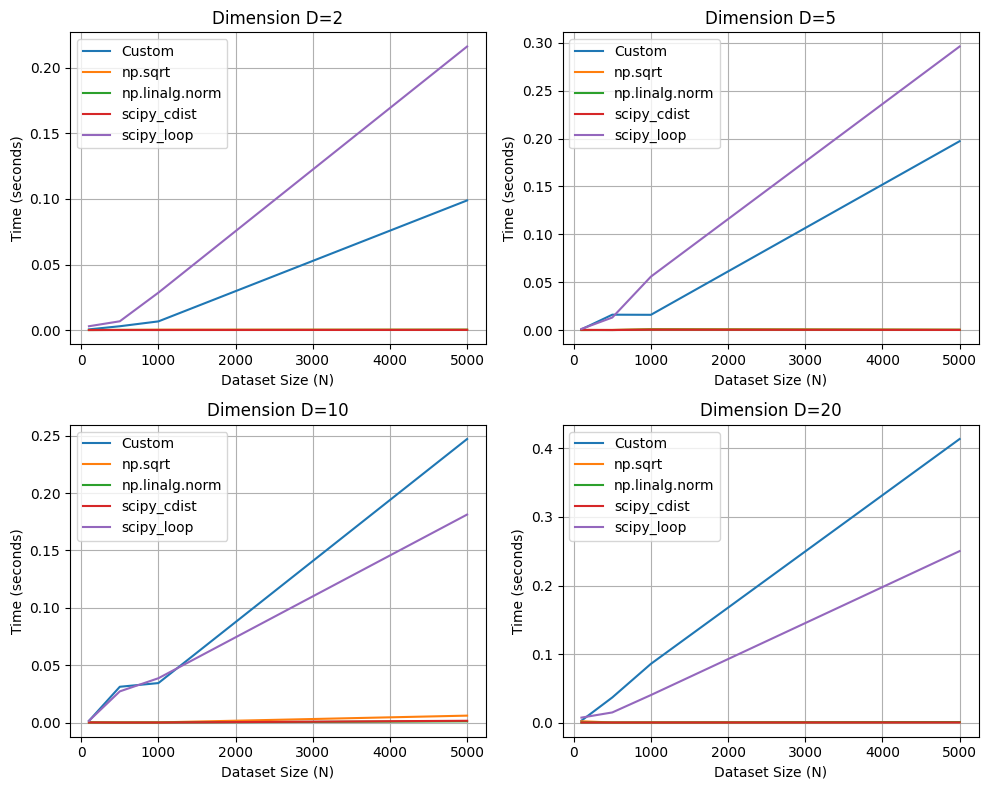

In [5]:
dataset_sizes = [100, 500, 1000, 5000]
dimensions_list = [2, 5, 10, 20]
methods = {
    'Custom': custom,
    'np.sqrt': np_sqrt,
    'np.linalg.norm': linalg_norm,
    'scipy_cdist': scipy_cdist,
    'scipy_loop': scipy_loop,
}

results = {method: [] for method in methods.keys()}

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, fixed_dimension in enumerate(dimensions_list):
    ax = axes[i // 2, i % 2]

    method_times = {method_name: [] for method_name in methods.keys()}

    for N in dataset_sizes:
        data = np.random.rand(N, fixed_dimension)
        query_point = np.random.rand(fixed_dimension)

        print(f"Running for Dataset Size N={N}, Dimensions D={fixed_dimension}")

        for method_name, method in methods.items():
            start_time = time.time()
            method(query_point, data)
            elapsed_time = time.time() - start_time
            method_times[method_name].append((N, elapsed_time))

    for method_name, times in method_times.items():
        sizes, elapsed_times = zip(*times)
        ax.plot(sizes, elapsed_times, label=method_name)

    ax.set_title(f'Dimension D={fixed_dimension}')
    ax.set_xlabel('Dataset Size (N)')
    ax.set_ylabel('Time (seconds)')
    ax.grid(True)
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

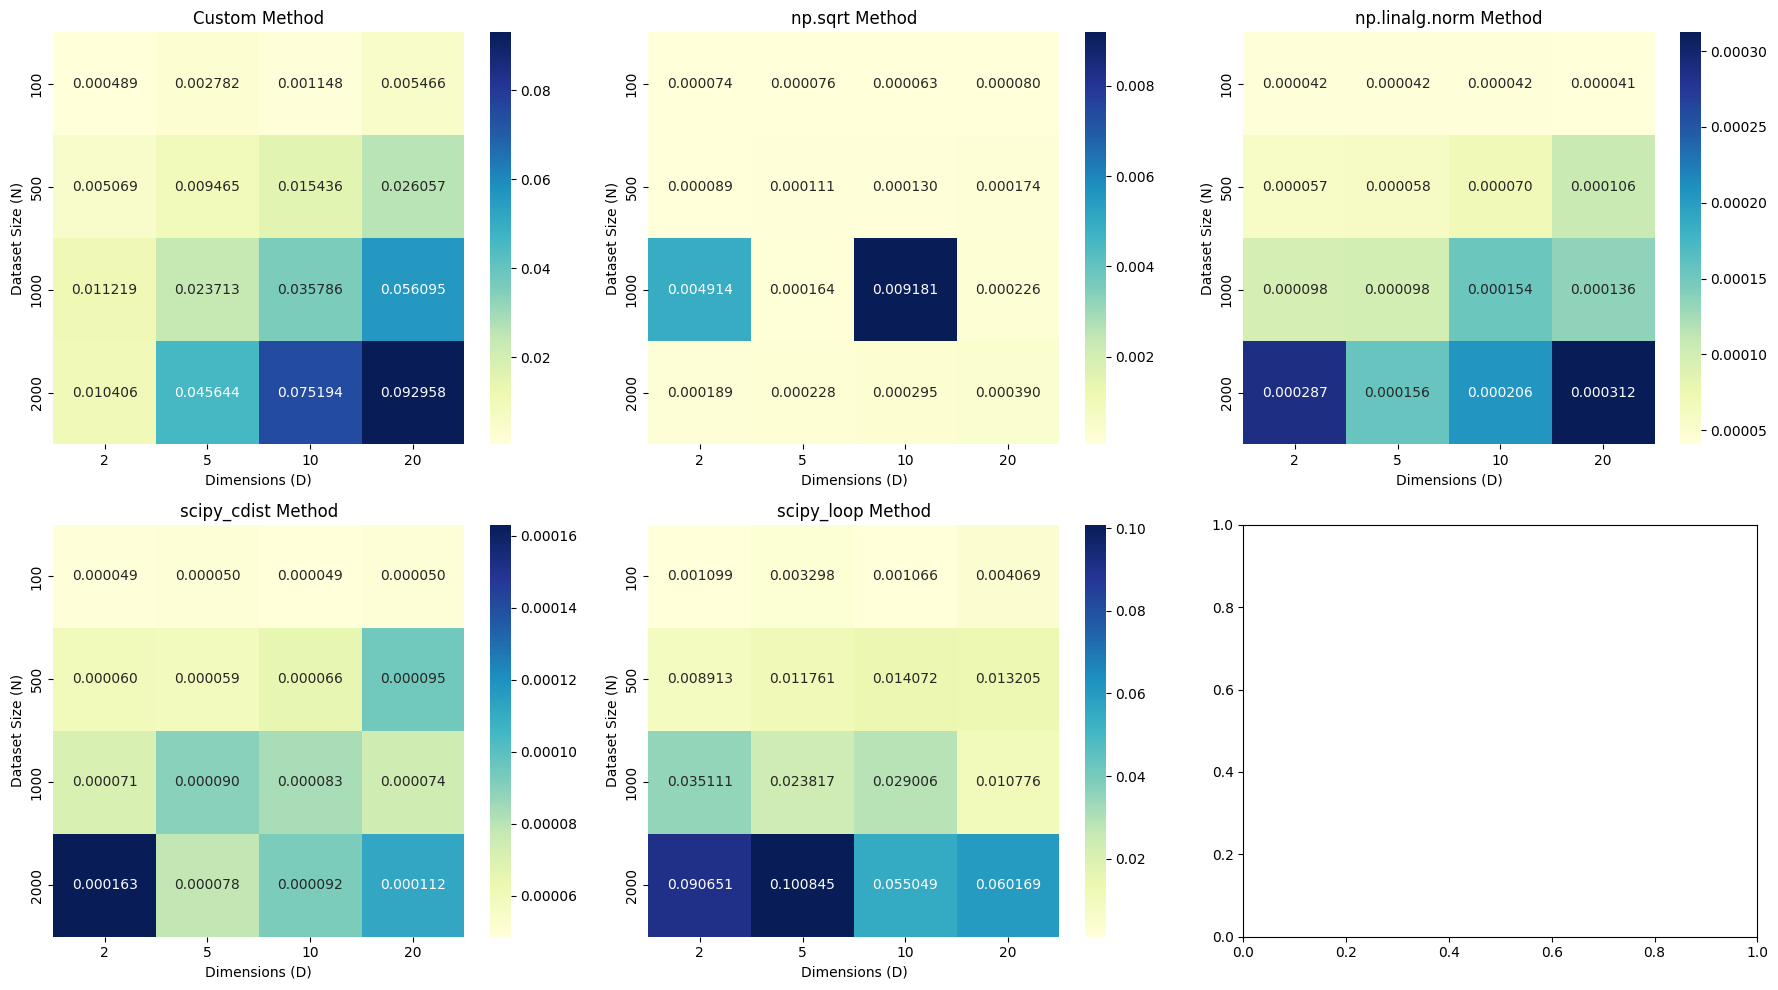

In [6]:
dataset_sizes = [100, 500, 1000, 2000]
dimensions = [2, 5, 10, 20]
methods = {
    'Custom': custom,
    'np.sqrt': np_sqrt,
    'np.linalg.norm': linalg_norm,
    'scipy_cdist': scipy_cdist,
    'scipy_loop': scipy_loop
}

heatmap_data = {method_name: np.zeros((len(dataset_sizes), len(dimensions))) for method_name in methods.keys()}


for i, N in enumerate(dataset_sizes):
    for j, D in enumerate(dimensions):
        data = np.random.rand(N, D)
        query_point = np.random.rand(D)

        for method_name, method in methods.items():
            start_time = time.time()
            method(query_point, data)
            elapsed_time = time.time() - start_time
            heatmap_data[method_name][i, j] = elapsed_time


fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()
for idx, (method_name, timing_matrix) in enumerate(heatmap_data.items()):
    sns.heatmap(timing_matrix, annot=True, fmt=".6f", cmap="YlGnBu", ax=axes[idx],
                xticklabels=dimensions, yticklabels=dataset_sizes)
    axes[idx].set_title(f'{method_name} Method')
    axes[idx].set_xlabel('Dimensions (D)')
    axes[idx].set_ylabel('Dataset Size (N)')


plt.tight_layout()
plt.show()

In [7]:
def knn_naive(data, query_points, k):
    neighbors = []
    for q in query_points:
        dists = np.linalg.norm(data - q, axis=1)
        nearest_indices = np.argsort(dists)[:k]
        neighbors.append(data[nearest_indices])
    return neighbors


def knn_kdtree(data, query_points, k):
    kdtree = KDTree(data)
    neighbors = []
    for q in query_points:
        _, idx = kdtree.query([q], k=k)
        neighbors.append(data[idx[0]])
    return neighbors


def knn_lsh(data, query_points, k, n_neighbors=10):
    lsh_nn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto', n_jobs=-1)
    lsh_nn.fit(data)
    neighbors = []
    for q in query_points:
        _, idx = lsh_nn.kneighbors([q], n_neighbors=k)
        neighbors.append(data[idx[0]])
    return neighbors

In [8]:
def plot_knn_partitions(data_points, query_point, nearest_indices, x_min=0, x_max=1, y_min=0, y_max=1, grid_size=100):

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_size), np.linspace(y_min, y_max, grid_size))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    def calculate_partition_indices(data, indices, grid_points):
        assigned_labels = []
        for point in grid_points:
            neighbor_points = data[indices]
            dists = distance.cdist([point], neighbor_points, metric='euclidean')
            closest_index = np.argmin(dists)
            assigned_labels.append(indices[closest_index])
        return np.array(assigned_labels).reshape(xx.shape)

    fig, axs = plt.subplots(1, len(nearest_indices), figsize=(6 * len(nearest_indices), 6))
    method_titles = list(nearest_indices.keys())

    for i, method in enumerate(method_titles):
        indices = nearest_indices[method]

        labels = calculate_partition_indices(data_points, indices, grid_points)

        axs[i].contourf(xx, yy, labels, alpha=0.3, cmap='viridis')
        axs[i].scatter(data_points[:, 0], data_points[:, 1], c='red', label='Data Points')
        axs[i].scatter(query_point[0], query_point[1], c='blue', label='Query Point')
        axs[i].scatter(data_points[indices, 0], data_points[indices, 1], c='yellow', s=100, label='Nearest Neighbors')
        axs[i].set_title(f"{method} Partition")
        axs[i].legend()

    plt.show()

In [9]:
def plot_knn_subplots(data, query_point, naive_result, kd_tree_result, lsh_result):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].scatter(data[:, 0], data[:, 1], color='blue', label='Data points')
    axes[0].scatter(query_point[0], query_point[1], color='red',
                    label='Query Point', s=100, edgecolors='black')
    for idx in naive_result:
        axes[0].scatter(data[idx, 0], data[idx, 1], color='yellow', marker='x',
                        label='Naive KNN Neighbors' if idx == naive_result[0] else "")
    axes[0].set_title("Naive KNN Neighbors")
    axes[0].legend(loc='upper right')
    axes[0].grid(True)

    axes[1].scatter(data[:, 0], data[:, 1], color='blue', label='Data points')
    axes[1].scatter(query_point[0], query_point[1], color='red',
                    label='Query Point', s=100, edgecolors='black')
    temp = 1
    for idx in naive_result:
      if idx not in kd_tree_result:
        axes[1].scatter(data[idx, 0], data[idx, 1], color='red', marker='x',
                        label='missed neighbours' if temp == 1 else "")
        temp = 0
    for idx in kd_tree_result:
        axes[1].scatter(data[idx, 0], data[idx, 1], color='yellow', marker='x',
                        label='KD-Tree Neighbors' if idx == kd_tree_result[0] else "")
    axes[1].set_title("KD-Tree neighbours")
    axes[1].legend(loc='upper right')
    axes[1].grid(True)

    axes[2].scatter(data[:, 0], data[:, 1], color='blue', label='Data points')
    axes[2].scatter(query_point[0], query_point[1], color='red',
                    label='Query Point', s=100, edgecolors='black')
    temp = 1
    for idx in naive_result:
      if idx not in lsh_result:
        axes[2].scatter(data[idx, 0], data[idx, 1], color='red', marker='x',
                        label='missed neighbours' if temp == 1 else "")
        temp = 0
    for idx in lsh_result:
        axes[2].scatter(data[idx, 0], data[idx, 1], color='yellow', marker='x',
                        label='LSH Neighbors' if idx == lsh_result[0] else "")
    axes[2].set_title("LSH neibhours")
    axes[2].legend(loc='upper right')
    axes[2].grid(True)


    plt.tight_layout()
    plt.show()

In [10]:
def naive_knn(query_point, data, k=3):
    distances = []
    for i, point in enumerate(data):
        dist = np.linalg.norm(point - query_point)
        distances.append((dist, i))

    distances.sort(key=lambda x: x[0])

    return [index for _, index in distances[:k]]

In [11]:
import numpy as np
import heapq

def build_kd_tree(data, depth=0):
    if len(data) == 0:
        return None

    k = data.shape[1]
    axis = depth % k

    sorted_data = data[data[:, axis].argsort()]
    median_index = len(sorted_data) // 2
    node = {
        'point': sorted_data[median_index],
        'left': build_kd_tree(sorted_data[:median_index], depth + 1),
        'right': build_kd_tree(sorted_data[median_index + 1:], depth + 1),
    }
    return node

def find_nearest_kd_tree(node, query_point, k, depth=0, neighbors=None):
    if node is None:
        return neighbors

    if neighbors is None:
        neighbors = []

    k_nearest = neighbors
    dist = np.linalg.norm(node['point'] - query_point)

    heapq.heappush(k_nearest, (-dist, node['point']))

    if len(k_nearest) > k:
        heapq.heappop(k_nearest)

    axis = depth % len(query_point)

    if query_point[axis] < node['point'][axis]:
        k_nearest = find_nearest_kd_tree(node['left'], query_point, k, depth + 1, k_nearest)
        if len(k_nearest) < k or abs(query_point[axis] - node['point'][axis]) < -k_nearest[0][0]:
            k_nearest = find_nearest_kd_tree(node['right'], query_point, k, depth + 1, k_nearest)
    else:
        k_nearest = find_nearest_kd_tree(node['right'], query_point, k, depth + 1, k_nearest)
        if len(k_nearest) < k or abs(query_point[axis] - node['point'][axis]) < -k_nearest[0][0]:
            k_nearest = find_nearest_kd_tree(node['left'], query_point, k, depth + 1, k_nearest)

    return k_nearest

In [12]:
def kd_tree_knn(data, query_point, k=3):
    tree = build_kd_tree(data)

    nearest_neighbors = find_nearest_kd_tree(tree, query_point, k)

    indices = [np.where(np.all(data == neighbor[1], axis=1))[0][0] for neighbor in nearest_neighbors]

    return indices

data1 = np.random.rand(50, 2)
query_point1 = np.random.rand(2)
k1 = 3


kd_tree_result1 = kd_tree_knn(data1, query_point1, k1)
print("KD-Tree KNN Results (Indices):", kd_tree_result1)

data2 = np.random.rand(100, 2)
query_point2 = np.random.rand(2)
k2 = 3


kd_tree_result2 = kd_tree_knn(data2, query_point2, k2)
print("KD-Tree KNN Results (Indices):", kd_tree_result2)

data3 = np.random.rand(500, 2)
query_point3 = np.random.rand(2)
k3 = 5

kd_tree_result3 = kd_tree_knn(data3, query_point3, k3)
print("KD-Tree KNN Results (Indices):", kd_tree_result3)

KD-Tree KNN Results (Indices): [48, 32, 37]
KD-Tree KNN Results (Indices): [98, 83, 39]
KD-Tree KNN Results (Indices): [348, 425, 44, 288, 118]


In [13]:
def hash_function(data, num_hashes):
    return [np.random.randn(data.shape[1]) for _ in range(num_hashes)]

def hash_point(point, hash_funcs):
    return tuple(np.dot(point, func) >= 0 for func in hash_funcs)

def build_lsh_tables(data, num_hashes, num_tables):
    tables = [defaultdict(list) for _ in range(num_tables)]
    hash_funcs = hash_function(data, num_hashes)

    for i, point in enumerate(data):
        hashed_point = hash_point(point, hash_funcs)
        for table in tables:
            table[hashed_point].append(i)

    return tables, hash_funcs

def lsh_knn(query_point, data, k=3, num_hashes=10, num_tables=5):
    tables, hash_funcs = build_lsh_tables(data, num_hashes, num_tables)

    hashed_query = hash_point(query_point, hash_funcs)

    candidates = set()

    for table in tables:

        if hashed_query in table:
            candidates.update(table[hashed_query])

    if len(candidates) == 0:
        return []

    distances = [(i, np.linalg.norm(data[i] - query_point)) for i in candidates]
    distances.sort(key=lambda x: x[1])
    return [i for i, _ in distances[:k]]

In [14]:
dataset_sizes = [100, 500, 1000, 5000]
dimensions = [2, 5, 10]
k = 5
results = { 'naive': [], 'kdtree': [], 'lsh': [] }

In [15]:
for N in dataset_sizes:
    for D in dimensions:
        data = np.random.rand(N, D)
        query_points = np.random.rand(10, D)

        # Naive KNN
        start_time = time.time()
        tracemalloc.start()
        knn_naive(data, query_points, k)
        memory_naive = tracemalloc.get_traced_memory()[1]
        tracemalloc.stop()
        time_naive = time.time() - start_time
        results['naive'].append((N, D, time_naive, memory_naive))

        # KD-Tree KNN
        start_time = time.time()
        tracemalloc.start()
        knn_kdtree(data, query_points, k)
        memory_kdtree = tracemalloc.get_traced_memory()[1]
        tracemalloc.stop()
        time_kdtree = time.time() - start_time
        results['kdtree'].append((N, D, time_kdtree, memory_kdtree))

        # LSH KNN
        start_time = time.time()
        tracemalloc.start()
        knn_lsh(data, query_points, k)
        memory_lsh = tracemalloc.get_traced_memory()[1]
        tracemalloc.stop()
        time_lsh = time.time() - start_time
        results['lsh'].append((N, D, time_lsh, memory_lsh))


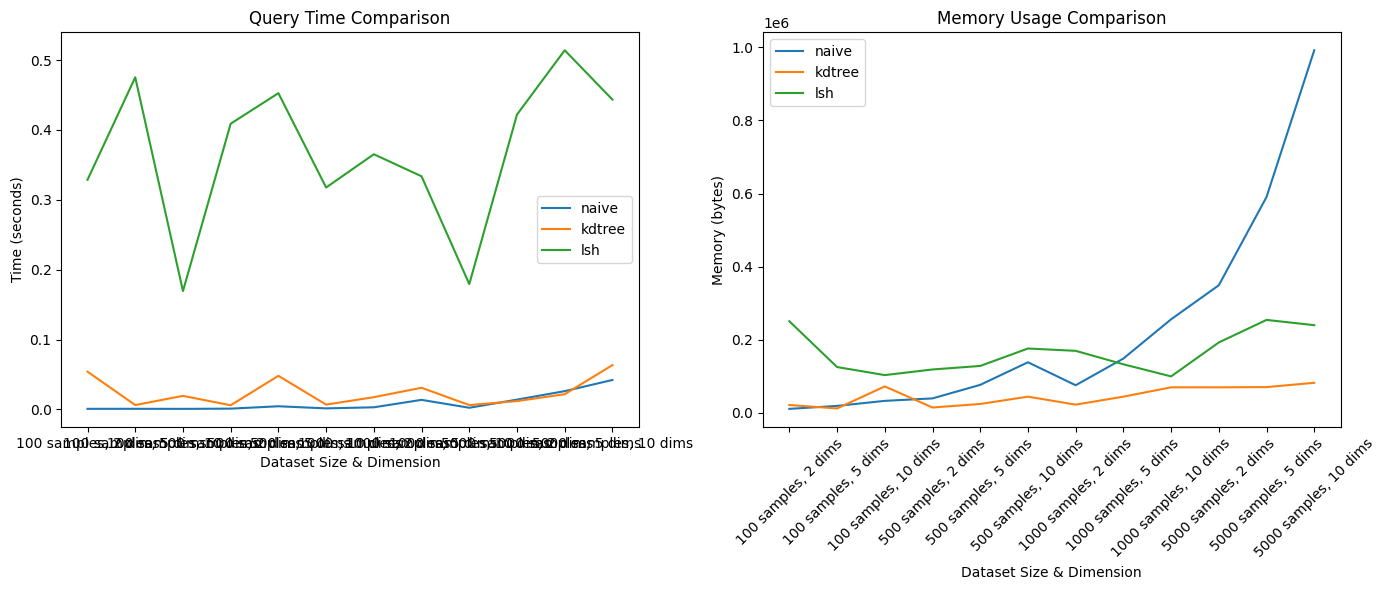

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plotting Query Time
for method in results.keys():
    times = [x[2] for x in results[method]]
    dataset_labels = [f"{x[0]} samples, {x[1]} dims" for x in results[method]]
    axes[0].plot(dataset_labels, times, label=method)
axes[0].set_title('Query Time Comparison')
axes[0].set_xlabel('Dataset Size & Dimension')
axes[0].set_ylabel('Time (seconds)')
axes[0].legend()

# Plotting Memory Usage
for method in results.keys():
    memories = [x[3] for x in results[method]]
    axes[1].plot(dataset_labels, memories, label=method)
axes[1].set_title('Memory Usage Comparison')
axes[1].set_xlabel('Dataset Size & Dimension')
axes[1].set_ylabel('Memory (bytes)')
axes[1].legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
print("n = 50", "d = 2", "k = 3")

naive_result1 = naive_knn(query_point1, data1, k1)
print("Naive KNN Result:", naive_result1)

print("KD-Tree Result:", kd_tree_result1)

lsh_result1 = lsh_knn(query_point1, data1, k1)
print("LSH Result:", lsh_result1)

n = 50 d = 2 k = 3
Naive KNN Result: [32, 37, 48]
KD-Tree Result: [48, 32, 37]
LSH Result: [32, 37, 48]


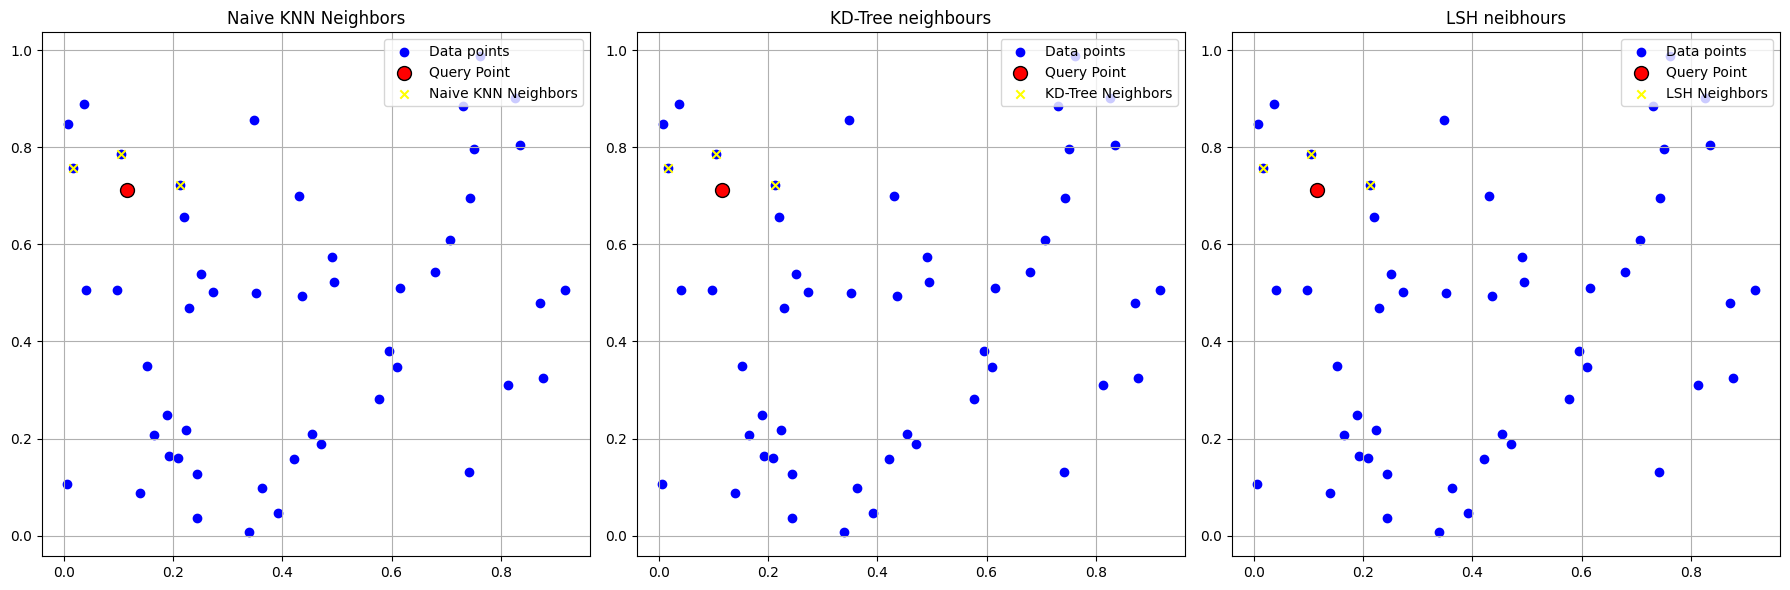

In [18]:
plot_knn_subplots(data1, query_point1, naive_result1, kd_tree_result1, lsh_result1)

In [19]:
nearest_indices = {
    'Naive KNN': naive_result1,
    'KD-Tree': kd_tree_result1,
    'LSH': lsh_result1
}

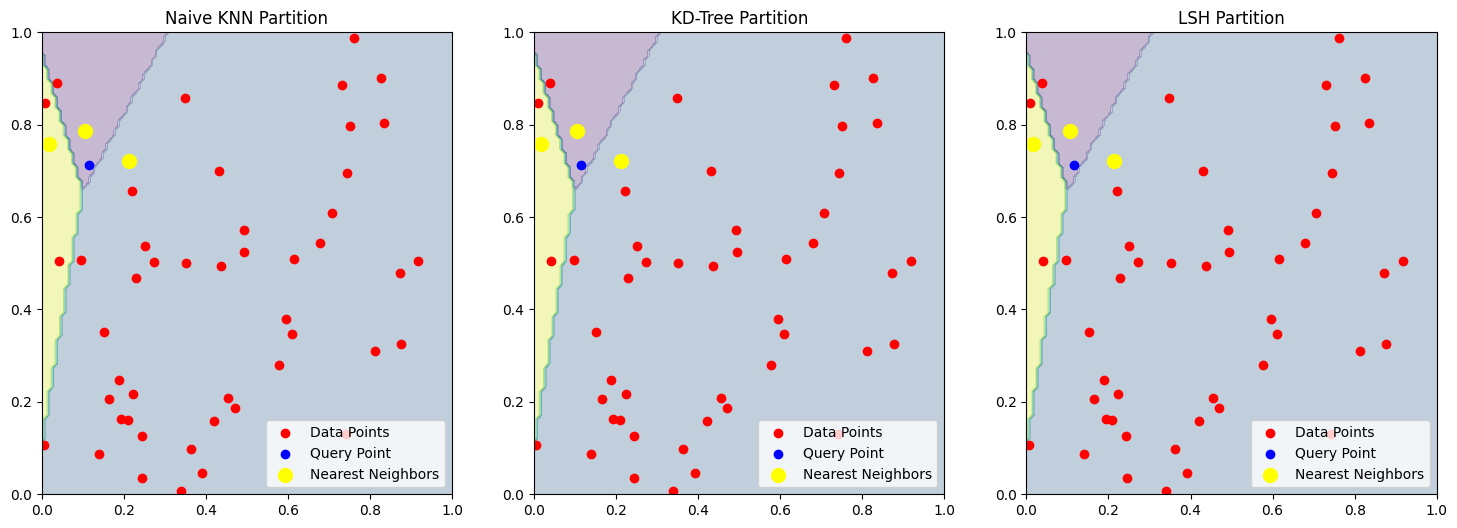

In [20]:
plot_knn_partitions(data1, query_point1, nearest_indices)

In [21]:
print("n = 100", "d = 2", "k = 3")

naive_result2 = naive_knn(query_point2, data2, k2)
print("Naive KNN Result:", naive_result2)

print("KD-Tree Result:", kd_tree_result2)

lsh_result2 = lsh_knn(query_point2, data2, k2)
print("LSH Result:", lsh_result2)

n = 100 d = 2 k = 3
Naive KNN Result: [39, 83, 98]
KD-Tree Result: [98, 83, 39]
LSH Result: [39, 83, 98]


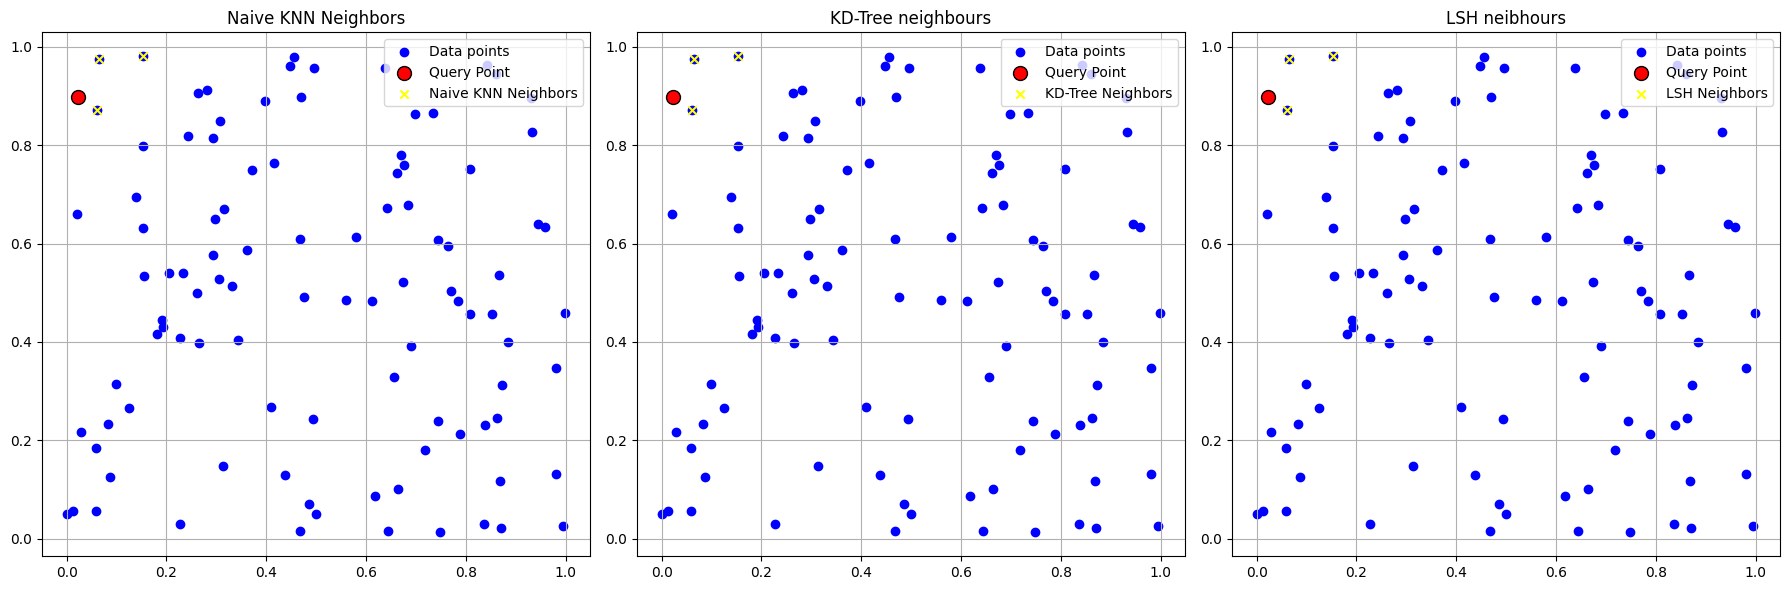

In [22]:
plot_knn_subplots(data2, query_point2, naive_result2, kd_tree_result2, lsh_result2)

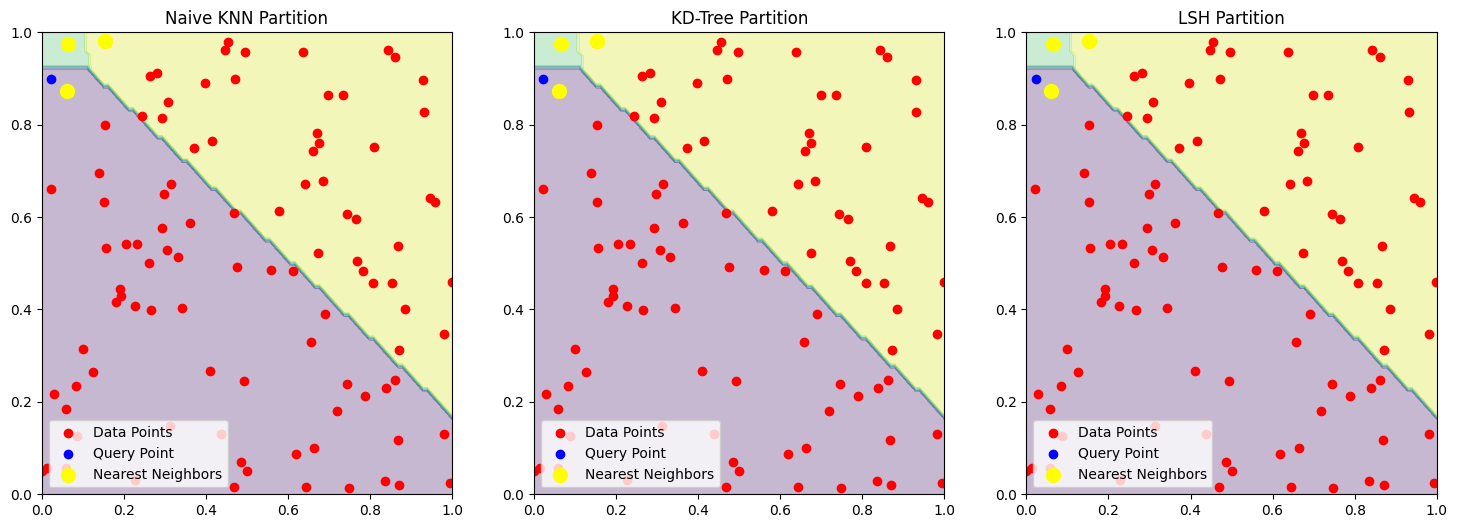

In [23]:
nearest_indices = {
    'Naive KNN': naive_result2,
    'KD-Tree': kd_tree_result2,
    'LSH': lsh_result2
}
plot_knn_partitions(data2, query_point2, nearest_indices)

In [24]:
print("n = 500", "d = 2", "k = 5")

naive_result3 = naive_knn(query_point3, data3, k3)
print("Naive KNN Result:", naive_result3)

print("KD-Tree Result:", kd_tree_result3)

lsh_result3 = lsh_knn(query_point3, data3, k3)
print("LSH Result:", lsh_result3)

n = 500 d = 2 k = 5
Naive KNN Result: [118, 288, 44, 425, 348]
KD-Tree Result: [348, 425, 44, 288, 118]
LSH Result: [118, 44, 425, 348, 457]


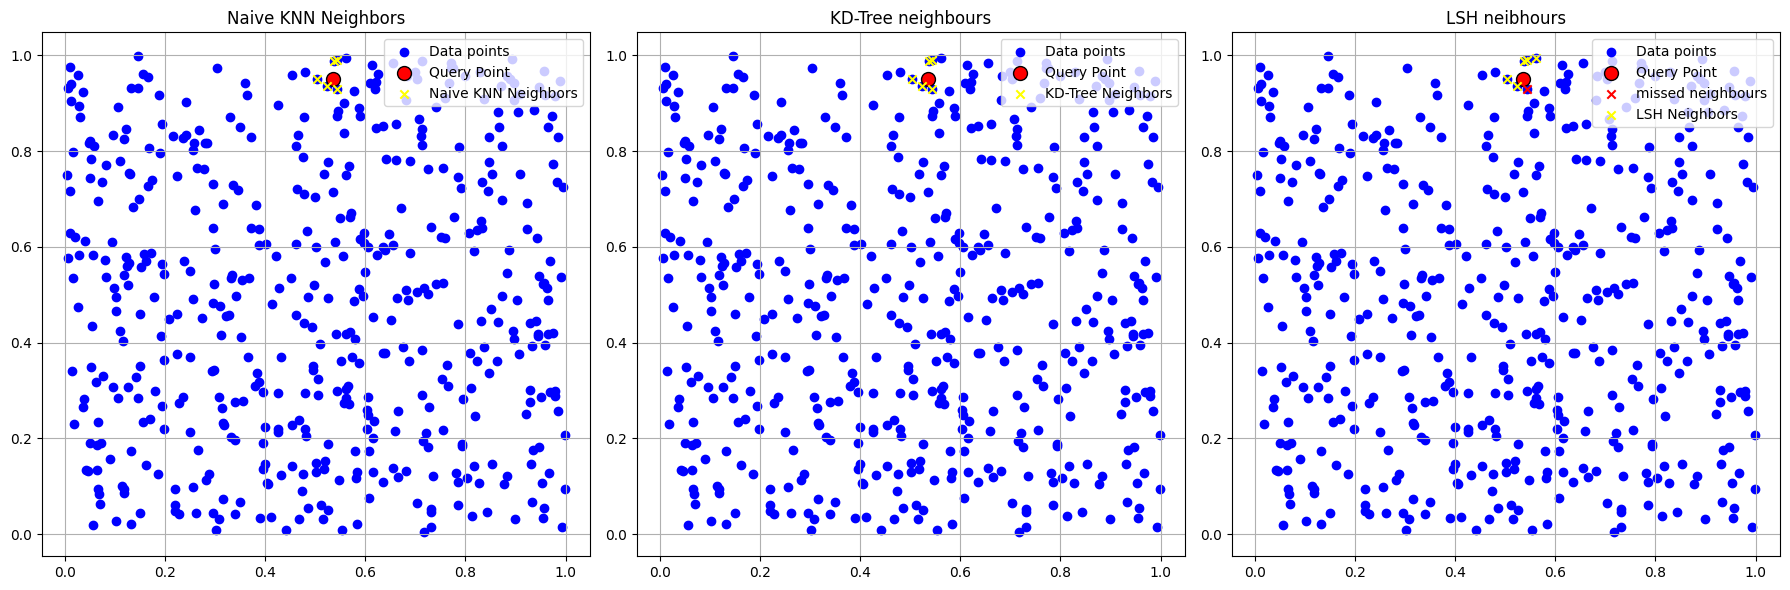

In [25]:
plot_knn_subplots(data3, query_point3, naive_result3, kd_tree_result3, lsh_result3)

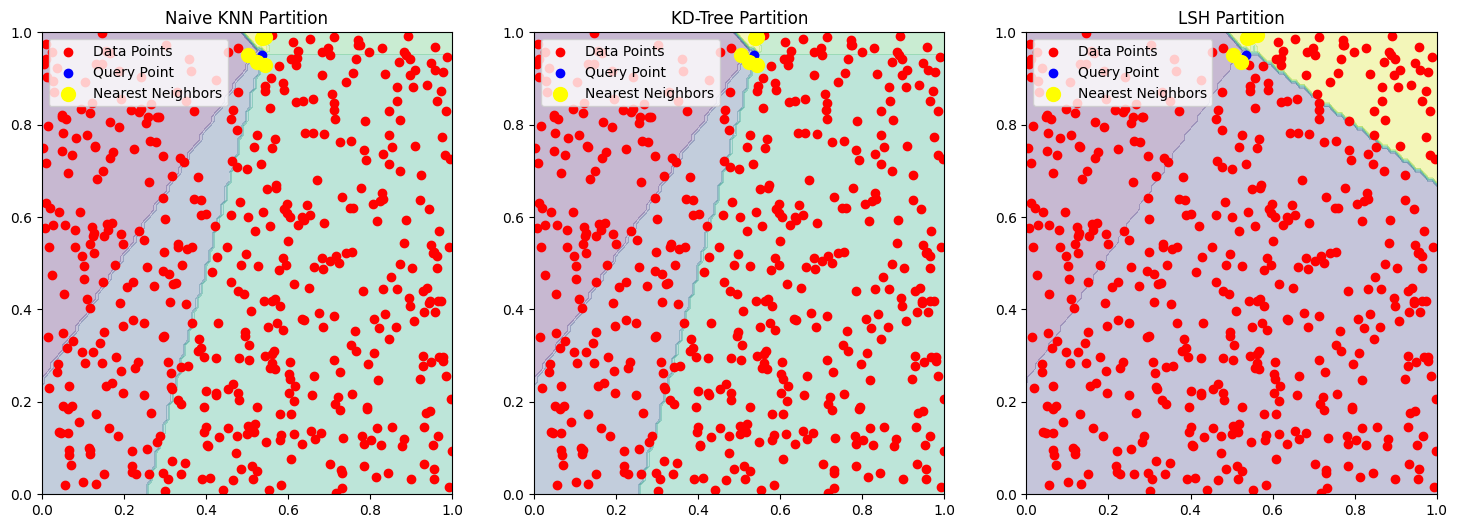

In [26]:
nearest_indices = {
    'Naive KNN': naive_result3,
    'KD-Tree': kd_tree_result3,
    'LSH': lsh_result3
}
plot_knn_partitions(data3, query_point3, nearest_indices)